## EP-WXT数据产品提取

目标：流水线产品不可用，我需要重新提取数据，每一次观测数据含有event文件，需要通过xselect软件从event中提取数据产品，数据产品包括能谱（包括源和背景能谱）和光变曲线（源和背景的光变曲线）。



思路：
- 1. 我知道目标源的坐标，可以生成源和背景的区域文件（src1.reg和bkg1.reg）；
- 2. 使用xselect读取event文件，导入reg提取能谱和光变曲线。

目的：`处理值班认证的2-3级数据`

### <span style="color:red">先进入`elisa`的Python虚拟环境</span>

### 1. 生成src.reg和bkg.reg

In [1]:
from extract_region import write_ds9_annulus_region,write_ds9_circle_region,parse_filename
import os
import subprocess
from datetime import datetime as dt
import math
from astropy.io import fits
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/wangboting/python-style/main/pythonstyle.style')
plt.rcParams['font.sans-serif'] = ['SimSun']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'


ep_wxt_filename = 'ep06800000699wxtCMOS8s3v1'

ra_src,dec_src = 290.142, -5.438
ra_bkg,dec_bkg = 290.142, -5.438
date = '20250729'
os.chdir(f'/Users/btwang/workshop/EP/WXT_datasets/{date}/{ep_wxt_filename}')
print("当前目录:", os.getcwd())
output_dir = "."
print("output_dir:",output_dir)
obsid, cmos_num, src_num = parse_filename(ep_wxt_filename)
print(f"  解析结果 -> obsid={obsid}, cmos_num={cmos_num}, src_num={src_num}")







src_reg = f'src{src_num}.reg'
## 记得手动修改reg注释
### WXT选源原则：67像素的圆，8.108 arcsec /pixel ,相当于 9 arcmin
comment_src = f's{src_num}'
src_reg_path = write_ds9_circle_region(ra_src, dec_src, output_dir, src_reg,comment=comment_src)
print(f'Region file saved to: {src_reg_path}')

bkg_reg = f'bkg{src_num}.reg'

#bkg_reg_path = write_ds9_annulus_region(ra_bkg, dec_bkg, output_dir, bkg)
bkg_reg_path = write_ds9_annulus_region(ra_src, dec_src, output_dir, bkg_reg)
print(f'Region file saved to: {bkg_reg_path}')

当前目录: /Users/btwang/workshop/EP/WXT_datasets/20250729/ep06800000699wxtCMOS8s3v1
output_dir: .
  解析结果 -> obsid=06800000699, cmos_num=8, src_num=3
Region file saved to: ./src3.reg
Region file saved to: ./bkg3.reg


### 2. xselect提取能谱和光变曲线数据产品

`heasoftpy` 不支持直接调用 `xselect`。不过我们可以通过写`.xco`实现自动提取数据产品。这里我通过`python`针对上一步得到的 `    src1.reg` 和`bkg1.reg`文件，写一个脚本。

In [2]:
# 写入 XSELECT 脚本
print("当前目录:", os.getcwd())
evt_file = f'ep{obsid}wxt{cmos_num}po_cl.evt'
src_spec = f'src{src_num}_spec.pha'
bkg_spec = f'bkg{src_num}_spec.pha'
src_lc = f'src{src_num}_lc.lc'
bkg_lc = f'bkg{src_num}_lc.lc'
image_src = f'src{src_num}_img.img'
###  源的能谱和光变曲线
xselect_src = f"""src
yes
set mission ep
read event {evt_file}
.
filter pha_cutoff 50 400
extract image xybinsize=16
save image {image_src}
clear pha_cutoff
filter region {src_reg}        
extract spectrum
save spectrum {src_spec}
extract curve
save curve {src_lc}

exit
no
"""

###  背景的能谱和光变曲线
xselect_bkg = f"""bkg
yes
set mission ep
read event {evt_file}
.
filter region {bkg_reg}          
extract spectrum
save spectrum {bkg_spec}    
extract curve
save curve {bkg_lc}          
exit
no
"""

# 保存为 .xco 文件
with open("xselect_src.xco", "w") as f:
    f.write(xselect_src)

with open("xselect_bkg.xco", "w") as f:
    f.write(xselect_bkg)


#### 检查如果有输出同名文件，删除

if os.path.exists(src_spec):
    os.remove(src_spec)
    print(f"Deleted source pha file: {src_spec}")

if os.path.exists(bkg_spec):
    os.remove(bkg_spec)
    print(f"Deleted background pha file: {bkg_spec}")

if os.path.exists(src_lc):
    os.remove(src_lc)
    print(f"Deleted source lc file: {src_lc}")

if os.path.exists(bkg_lc):
    os.remove(bkg_lc)
    print(f"Deleted background lc file: {bkg_lc}")

if os.path.exists(image_src):
    os.remove(image_src)
    print(f"Deleted background lc file: {image_src}")

当前目录: /Users/btwang/workshop/EP/WXT_datasets/20250729/ep06800000699wxtCMOS8s3v1
Deleted source pha file: src3_spec.pha
Deleted background pha file: bkg3_spec.pha
Deleted source lc file: src3_lc.lc
Deleted background lc file: bkg3_lc.lc
Deleted background lc file: src3_img.img


###  2.1 源的能谱和光变曲线

In [3]:
# 调用 XSELECT（需要 HEASoft 环境已激活）
subprocess.run("xselect  @xselect_src.xco", shell=True, check=True)

 
                         **  XSELECT V2.5b  **
 
!> Enter session name >[bkg] src
 Command not found; type ? for a command listing
!src:SUZAKU > yes
 Command not found; type ? for a command listing
!src:SUZAKU > set mission ep
!src:EP > read event ep06800000699wxt8po_cl.evt
!> Enter the Event file dir >[.] .
 
 
        OBJECT      DETNAM      OBS_ID      DATE-OBS                DATAMODE
      1 06800000699 CMOS8       06800000699 2025-06-28T10:25:30.984 PHOTON
 
 Notes: XSELECT set up for      EP
 Time keyword is TIME       in units of s
 Default timing binsize =   5.0000
 
Setting...
 Image  keywords   = X          Y           with binning =    1
 WMAP   keywords   = X          Y           with binning =    1
 Energy keyword   = PI                     with binning =    1
 
Getting Min and Max for Energy Column...
Got min and max for PI:     0   1023
 
Got the minimum time resolution of the read data:  0.50000E-01
MJDREF =  5.8849000800741E+04 with TIMESYS = TT
 Number of files read

CompletedProcess(args='xselect  @xselect_src.xco', returncode=0)

###  2.2 背景的能谱和光变曲线

In [4]:
subprocess.run("xselect  @xselect_bkg.xco", shell=True, check=True)

 
                         **  XSELECT V2.5b  **
 
!> Enter session name >[src] bkg
 Command not found; type ? for a command listing
!bkg:SUZAKU > yes
 Command not found; type ? for a command listing
!bkg:SUZAKU > set mission ep
!bkg:EP > read event ep06800000699wxt8po_cl.evt
!> Enter the Event file dir >[.] .
 
 
        OBJECT      DETNAM      OBS_ID      DATE-OBS                DATAMODE
      1 06800000699 CMOS8       06800000699 2025-06-28T10:25:30.984 PHOTON
 
 Notes: XSELECT set up for      EP
 Time keyword is TIME       in units of s
 Default timing binsize =   5.0000
 
Setting...
 Image  keywords   = X          Y           with binning =    1
 WMAP   keywords   = X          Y           with binning =    1
 Energy keyword   = PI                     with binning =    1
 
Getting Min and Max for Energy Column...
Got min and max for PI:     0   1023
 
Got the minimum time resolution of the read data:  0.50000E-01
MJDREF =  5.8849000800741E+04 with TIMESYS = TT
 Number of files read

CompletedProcess(args='xselect  @xselect_bkg.xco', returncode=0)

### 3. 画光变曲线
#### <span style="color:red">3.1 使用 `lcmath` 提取净光变曲线</span>
#### 3.1.1 提取backscal参数

In [5]:
with fits.open(f"{src_spec}") as hdul:
    # 打印包含的 HDU 列表
    scal_src = hdul[1].header.get("BACKSCAL")
    print("src_BACKSCAL =", scal_src)

with fits.open(f"{bkg_spec}") as hdul:
    # 打印包含的 HDU 列表
    scal_bkg = hdul[1].header.get("BACKSCAL")
    print("bkg_BACKSCAL =", scal_bkg)

src_BACKSCAL = 0.0001396
bkg_BACKSCAL = 0.00165745


#### 3.1.2 计算缩放背景的因子

In [6]:
infile = src_lc 
bgfile = bkg_lc
outfile='net.lc'
multi = 1.0
multb = scal_src / scal_bkg
print("multb",multb)
# 确保输入文件存在
if not os.path.exists(infile):
    print(f"错误：输入文件 {infile} 不存在")
    exit(1)
if not os.path.exists(bgfile):
    print(f"错误：背景文件 {bgfile} 不存在")
    exit(1)
cmd = f"lcmath infile={infile} bgfile={bgfile} outfile={outfile} multi={multi} multb={multb:.5f} addsubr=no"



multb 0.08422576849980391


#### 3.1.3 提取净光变曲线

In [7]:
try:
    result = subprocess.run(cmd, check=True, capture_output=True, text=True, shell=True)
    print("Command output:", result.stdout)
except subprocess.CalledProcessError as e:
    print("Error occurred:")
    print("Command:", e.cmd)
    print("Return code:", e.returncode)
    print("Output:", e.stdout)
    print("Error:", e.stderr)

Command output: Net or Sum light curve will be corrected
  5% completed
 10% completed
 15% completed
 20% completed
 25% completed
 30% completed
 35% completed
 40% completed
 45% completed
 50% completed
 55% completed
 60% completed
 65% completed
 70% completed
 75% completed
 80% completed
 85% completed
 90% completed
 95% completed
100% completed



#### <span style="color:red">3.2 使用 `lcurve` 画出净光变曲线</span>

In [8]:
three_lc = 'net_src_bkg.lc'
plotfile = 'net_src_bkg.gif'


# Extract exposure time


# 获取 GTI 时间段总长度
def get_gti_exposure(filename):
    with fits.open(filename) as hdul:
        gti_data = None
        # 尝试找到 GTI extension
        for hdu in hdul:
            if hdu.name.upper() == 'GTI':
                gti_data = hdu.data
                break

        if gti_data is None:
            raise ValueError("未找到 GTI extension")

        # GTI 有 START 和 STOP 字段，求总有效曝光时间
        start_times = gti_data['START']
        stop_times = gti_data['STOP']
        total_exposure = sum(stop - start for start, stop in zip(start_times, stop_times))
        return total_exposure

# 获取曝光时间
try:
    exposure_time = get_gti_exposure(src_spec)
    print("GTI总曝光时间 = ", exposure_time)

    # Time binning
    time_bin = 60.0 # Time bin size
    bin_num = math.ceil(exposure_time / time_bin)
    print("bin_num（基于GTI）:", bin_num)

except Exception as e:
    print("出错：", e)
    exit(1)
# try:
#     with fits.open(f"{src_spec}") as hdul:
#         exposure_time = hdul[1].header.get("EXPOSURE")
#         t_start = hdul[1].header.get("TSTART")
#         t_stop = hdul[1].header.get("TSTOP")
#         time_difference = t_stop - t_start
#         print("exposure_time =", exposure_time)
#         print("time_difference =", time_difference)
# except NameError:
#     print("错误：变量 'src_spec' 未定义")
#     exit(1)
# except FileNotFoundError:
#     print(f"错误：输入文件 {src_spec} 不存在")
#     exit(1)

# Time binning
# time_bin = 60.0  # Time bin size
# bin_num = math.ceil(time_difference / time_bin)  # Number of bins
# print("bin_num:", bin_num)

# Check if input files exist
if not os.path.exists(outfile):
    print(f"错误：输入文件 {outfile} 不存在")
    exit(1)
if not os.path.exists(infile):
    print(f"错误：输入文件 {infile} 不存在")
    exit(1)
if not os.path.exists(bgfile):
    print(f"错误：背景文件 {bgfile} 不存在")
    exit(1)

# lcurve command with interactive plotting
cmd = f'lcurve nser=3 cfile1="{outfile}" cfile2="{infile}" cfile3="{bgfile}" window="-" dtnb={time_bin} nbint={bin_num} outfile="{three_lc}" plot=yes plotdev="/xw" plotdnum=3 clobber=yes'

# Commands to send to PLT> prompt
plt_commands = f"hardcopy {plotfile}/GIF\nexit\n"

try:
    # Run the command and pipe the PLT> commands
    result = subprocess.run(
        cmd,
        check=True,
        capture_output=True,
        text=True,
        shell=True,
        input=plt_commands
    )
    print("Command output:", result.stdout)
    print(f"Plot saved as: {plotfile}")
except subprocess.CalledProcessError as e:
    print("Error occurred:")
    print("Command:", e.cmd)
    print("Return code:", e.returncode)
    print("Output:", e.stdout)
    print("Error:", e.stderr)

GTI总曝光时间 =  3458.0
bin_num（基于GTI）: 58
Command output:  
lcurve 1.0 (xronos6.0)
 
 Series 1 file    1:net.lc
 
 Selected FITS extensions: 1 - RATE TABLE;
 
 Source ............ 06800000699         Start Time (d) .... 20854 10:49:40.984
 FITS Extension ....  1 - `RATE      `   Stop Time (d) ..... 20854 12:31:58.984
 No. of Rows .......          690        Bin Time (s) ......    5.000
 Right Ascension ... 0                   Internal time sys.. Converted to TJD
 Declination ....... 0                   Experiment ........ EP       WXT
 
 Corrections applied: Vignetting - No ; Deadtime - No ; Bkgd - Yes; Clock - No
             values: 1.00000000       1.00000000       1.00000000
 
 Selected Columns:  1- Time;  2- Y-axis;  3- Y-error;  4- Fractional exposure;
 
 File contains binned data.
 
 Series 2 file    1:src3_lc.lc
 
 Selected FITS extensions: 1 - RATE TABLE;
 
 Source ............ 06800000699         Start Time (d) .... 20854 10:49:40.984
 FITS Extension ....  1 - `RATE      `   Stop

In [9]:
three_lc = 'net_src_bkg.lc'
plotfile = 'net_src_bkg.gif'
time_bin = 60.0         # 时间分箱，单位：秒

# === Step 1：从 GTI 读取总有效曝光时间 ===
def get_gti_exposure(filename):
    with fits.open(filename) as hdul:
        gti_data = None
        for hdu in hdul:
            if hdu.name.upper() in ['GTI', 'STDGTI']:
                gti_data = hdu.data
                break
        if gti_data is None:
            raise ValueError("未找到 GTI extension")
        start_times = gti_data['START']
        stop_times = gti_data['STOP']
        total_exposure = sum(stop - start for start, stop in zip(start_times, stop_times))
        return total_exposure

try:
    exposure_time = get_gti_exposure(infile)  # 用源光变文件的 GTI
    print("GTI总曝光时间 =", exposure_time)

    bin_num = math.ceil(exposure_time / time_bin)
    print("bin_num（基于GTI）:", bin_num)
except Exception as e:
    print("出错：", e)
    exit(1)

# === Step 2：检查文件是否存在 ===
for f, name in zip([outfile, infile, bgfile], ['outfile', 'infile', 'bgfile']):
    if not os.path.exists(f):
        print(f"错误：输入文件 {name} ({f}) 不存在")
        exit(1)

# === Step 3：构造 lcurve 命令 ===
cmd = f'lcurve nser=3 cfile1="{outfile}" cfile2="{infile}" cfile3="{bgfile}" ' \
      f'window="-" dtnb={time_bin} nbint={bin_num} outfile="{three_lc}" ' \
      f'plot=yes plotdev="/xw" plotdnum=3 clobber=yes'

# === Step 4：发送给 PLT 的命令 ===
plt_commands = f"res y 0,0.15\nhardcopy {plotfile}/GIF\nexit\n"

# === Step 5：运行命令并自动传输 PLT 指令 ===
try:
    result = subprocess.run(
        cmd,
        check=True,
        capture_output=True,
        text=True,
        shell=True,
        input=plt_commands
    )
    print("lcurve 输出:", result.stdout)
    print(f"图已保存为: {plotfile}")
except subprocess.CalledProcessError as e:
    print("执行 lcurve 时出错：")
    print("命令:", e.cmd)
    print("返回码:", e.returncode)
    print("输出:", e.stdout)
    print("错误信息:", e.stderr)

GTI总曝光时间 = 3458.0
bin_num（基于GTI）: 58
lcurve 输出:  
lcurve 1.0 (xronos6.0)
 
 Series 1 file    1:net.lc
 
 Selected FITS extensions: 1 - RATE TABLE;
 
 Source ............ 06800000699         Start Time (d) .... 20854 10:49:40.984
 FITS Extension ....  1 - `RATE      `   Stop Time (d) ..... 20854 12:31:58.984
 No. of Rows .......          690        Bin Time (s) ......    5.000
 Right Ascension ... 0                   Internal time sys.. Converted to TJD
 Declination ....... 0                   Experiment ........ EP       WXT
 
 Corrections applied: Vignetting - No ; Deadtime - No ; Bkgd - Yes; Clock - No
             values: 1.00000000       1.00000000       1.00000000
 
 Selected Columns:  1- Time;  2- Y-axis;  3- Y-error;  4- Fractional exposure;
 
 File contains binned data.
 
 Series 2 file    1:src3_lc.lc
 
 Selected FITS extensions: 1 - RATE TABLE;
 
 Source ............ 06800000699         Start Time (d) .... 20854 10:49:40.984
 FITS Extension ....  1 - `RATE      `   Stop Time 

### 4. 能谱分析
#### <span style="color:red">4.1 使用grppha 合并能道,check `bkg.pha`,`rmf`,`arf` keywords to `src.pha`</span>

In [10]:
grp_infile = src_spec
grp_outfile = f'src{src_num}_spec.grp'
#grp_min_bins = 4 # 按需修改
bkg_file = bkg_spec
arf_file = f'ep{obsid}wxt{cmos_num}s{src_num}.arf' # 需修改为目标源的arf
rmf_file = f'ep{obsid}wxt{cmos_num}.rmf' # 需修改为目标源的rmf

# 手动bin
# cmd_grp = f'grppha {grp_infile} {grp_outfile}  comm="group min {grp_min_bins} & chkey backfile {bkg_file} & chkey respfile {rmf_file} & chkey ancrfile {arf_file} & clobber = yes & show keywords & exit"'

# elisa自动bin
cmd_grp = f'grppha {grp_infile} {grp_outfile}  comm="chkey backfile {bkg_file} & chkey respfile {rmf_file} & chkey ancrfile {arf_file} & clobber = yes & show keywords & exit"'


#### 注意⚠️：文件夹中已有输出文件，会报错，检查如果有输出同名文件，删除

if os.path.exists(grp_outfile):
    os.remove(grp_outfile)
    print(f"Deleted existing file: {grp_outfile}")


try:
    result = subprocess.run(cmd_grp, check=True, capture_output=True, text=True, shell=True)
    print("Command output:", result.stdout)
except subprocess.CalledProcessError as e:
    print("Error occurred:")
    print("Command:", e.cmd)
    print("Return code:", e.returncode)
    print("Output:", e.stdout)
    print("Error:", e.stderr)

Deleted existing file: src3_spec.grp
Command output:  
  -------------------------
  MANDATORY KEYWORDS/VALUES
  -------------------------
  --------------------------------------------------------------------
  --------------------------------------------------------------------
  EXTNAME   - SPECTRUM        Name of this BINTABLE
  TELESCOP  - EP              Mission/Satellite name
  INSTRUME  - WXT             Instrument/Detector
  FILTER    - NONE            Instrument filter in use
  EXPOSURE  - 3458.0          Integration time (in secs) of PHA data
  AREASCAL  - 1.0000          Area scaling factor
  BACKSCAL  - 1.39600E-04     Background scaling factor
  BACKFILE  - none            Associated background file
  CORRSCAL  - 1.0000          Correlation scaling factor
  CORRFILE  - none            Associated correlation file
  RESPFILE  - none            Associated redistribution matrix file
  ANCRFILE  - none            Associated ancillary response file
  POISSERR  - TRUE           

#### 4.2 使用`elisa`拟合能谱

/opt/miniconda3/envs/elisa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


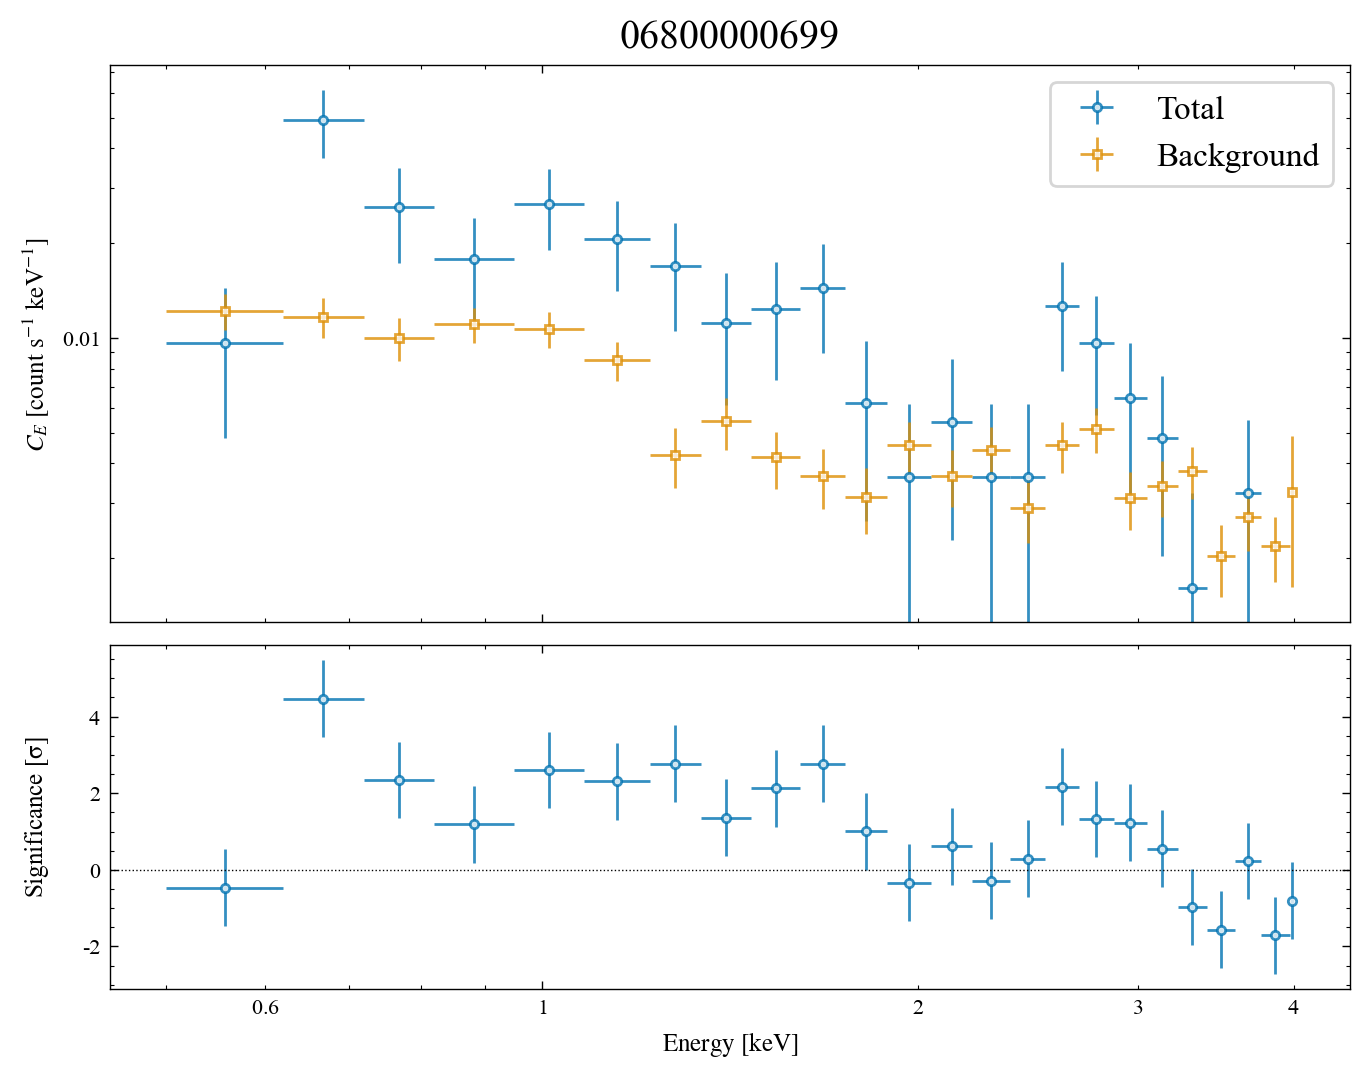

In [11]:
from elisa import BayesFit, MaxLikeFit,Data
from elisa.models import TBAbs, PowerLaw,BlackbodyRad
from elisa.models.xspec import XSagauss,XSdiskbb,XSapec
WXT = Data(name=f"{obsid}",
    erange=[0.5, 4.0],specfile=f'{grp_outfile}',group='opt')

fig_spec = WXT.plot_spec(xlog=True, data_ylog=True)
fig_spec.set_size_inches(8, 6)
plt.show()

In [12]:
data =[WXT]
# XSapec(kT, Abundanc, Redshift, norm)
model = TBAbs(nH=[0.34]) * PowerLaw(alpha=[1.8,-1,5], K=[1.1, 1e-5, 1e4])
# model = TBAbs(nH=[0.34]) * XSapec(kT=[0.8,0.008,5],norm=[1.1,1e-5,1e5])
fit = BayesFit(data=data,model=model,stat='wstat')
fit

Bayesian Fit

╭─────────────┬──────────────────┬───────────╮
│     Data    │      Model       │ Statistic │
├─────────────┼──────────────────┼───────────┤
│ 06800000699 │ TBAbs * PowerLaw │   wstat   │
╰─────────────┴──────────────────┴───────────╯

╭─────┬───────────┬───────────┬───────┬───────────────────────╮
│ No. │ Component │ Parameter │ Value │         Prior         │
├─────┼───────────┼───────────┼───────┼───────────────────────┤
│  1  │   TBAbs   │     nH    │  0.34 │   Uniform(0, 1e+06)   │
├─────┼───────────┼───────────┼───────┼───────────────────────┤
│  2  │  PowerLaw │   alpha   │  1.8  │     Uniform(-1, 5)    │
├─────┼───────────┼───────────┼───────┼───────────────────────┤
│  3  │  PowerLaw │     K     │  1.1  │ Uniform(1e-05, 1e+04) │
╰─────┴───────────┴───────────┴───────┴───────────────────────╯

In [13]:
posterior = fit.nuts(progress=False)
posterior

/opt/miniconda3/envs/elisa/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/miniconda3/envs/elisa/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Parameters
╭────────────────┬────────┬────────┬────────┬──────────────────┬──────┬──────╮
│   Parameter    │  Mean  │ StdDev │ Median │  68.3% Quantile  │ ESS  │ Rhat │
├────────────────┼────────┼────────┼────────┼──────────────────┼──────┼──────┤
│    TBAbs.nH    │  0.56  │  0.28  │ 0.539  │ [-0.249, 0.272]  │ 2355 │ 1.00 │
├────────────────┼────────┼────────┼────────┼──────────────────┼──────┼──────┤
│ PowerLaw.alpha │  3.36  │   1    │  3.42  │  [-1.18, 1.06]   │ 2321 │ 1.00 │
├────────────────┼────────┼────────┼────────┼──────────────────┼──────┼──────┤
│   PowerLaw.K   │ 0.0355 │ 0.0304 │ 0.0275 │ [-0.0142, 0.029] │ 2475 │ 1.00 │
╰────────────────┴────────┴────────┴────────┴──────────────────┴──────┴──────╯

Fit Statistics
╭─────────────┬───────────┬──────────┬──────────┬──────────╮
│     Data    │ Statistic │   Mean   │  Median  │ Channels │
├─────────────┼───────────┼──────────┼──────────┼──────────┤
│ 06800000699 │   wstat   │  33.91   │  33.28   │    24    │
├─────────────┼───────────┼──────────┼──────────┼──────────┤
│    Total    │  stat/dof │ 33.91/21 │ 33.28/21 │    24    │
╰─────────────┴───────────┴──────────┴──────────┴──────────╯

Information Criterion
╭────────┬───────────────┬──────╮
│ Method │    Deviance   │  p   │
├────────┼───────────────┼──────┤
│ LOOIC  │ 40.55 ± 13.17 │ 5.50 │
├────────┼───────────────┼──────┤
│  WAIC  │ 40.93 ± 13.82 │ 5.68 │
╰────────┴───────────────┴──────╯

Pareto k diagnostic
╭─────────────┬──────────┬───────┬───────╮
│    Range    │   Flag   │ Count │  Pct. │
├─────────────┼──────────┼───────┼───────┤
│ (-Inf, 0.5] │   good   │   21  │ 87.5% │
├─────────────┼──────────┼───────┼───────┤
│  (0.5, 0.7] │    ok    │   2   │  8.3% │
├─────────────┼──────────┼───────┼───────┤
│   (0.7, 1]  │   bad    │   0   │  0.0% │
├─────────────┼──────────┼───────┼───────┤
│   (1, Inf)  │ very bad │   1   │  4.2% │
╰─────────────┴──────────┴───────┴───────╯

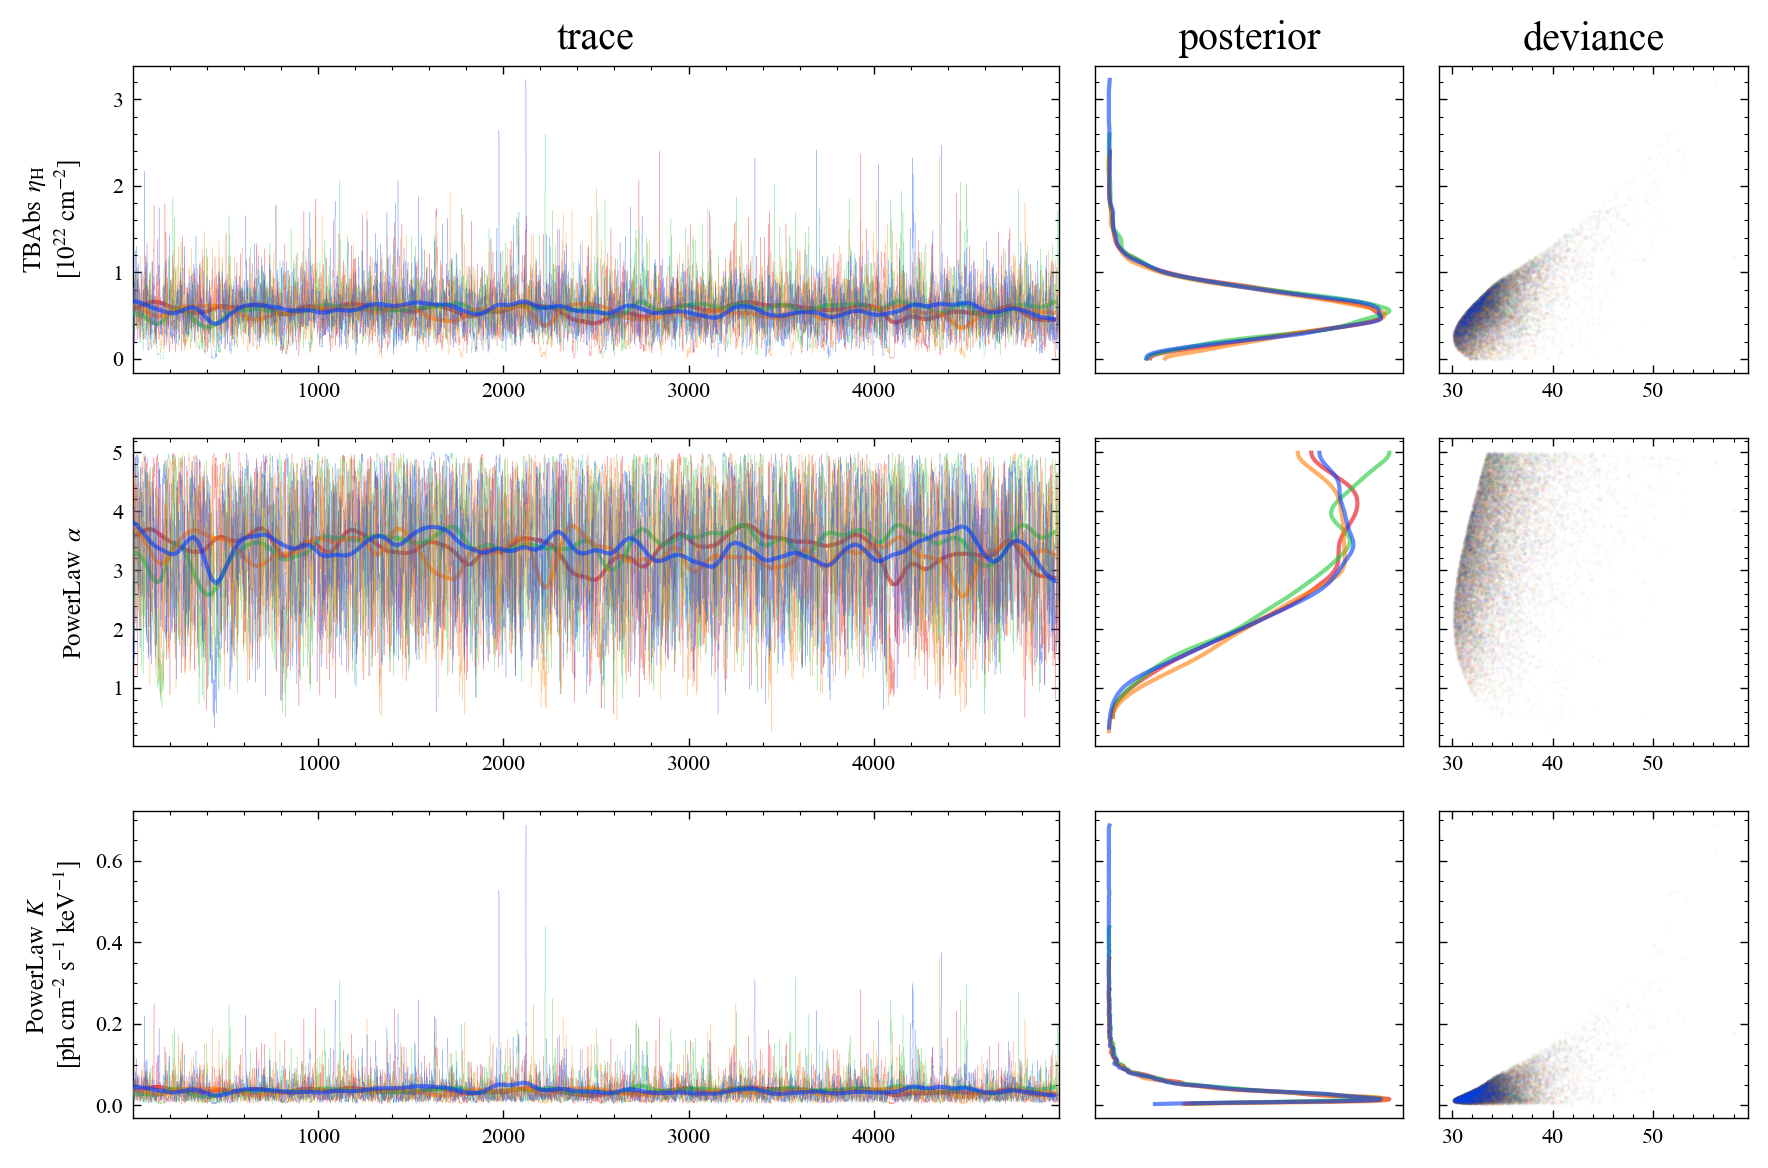

In [14]:
fig_trace = posterior.plot.plot_trace()

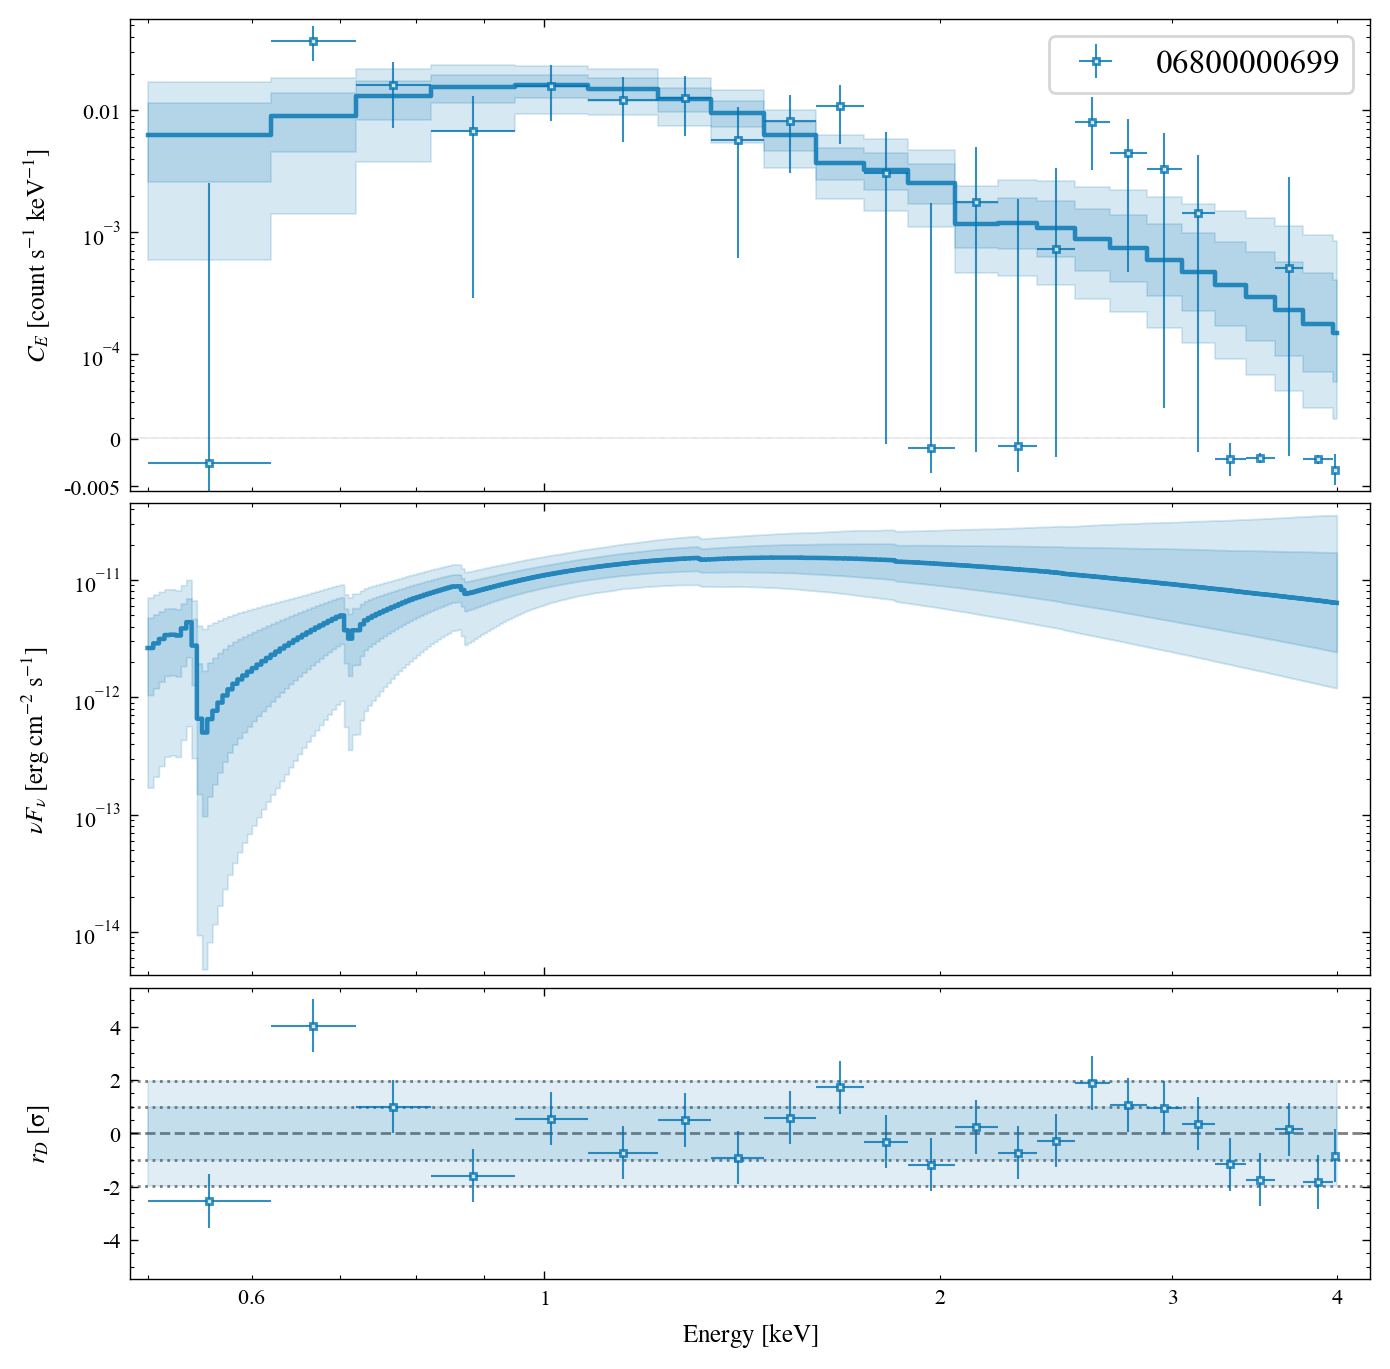

In [15]:
fit_result =posterior.plot("data vFv rd")

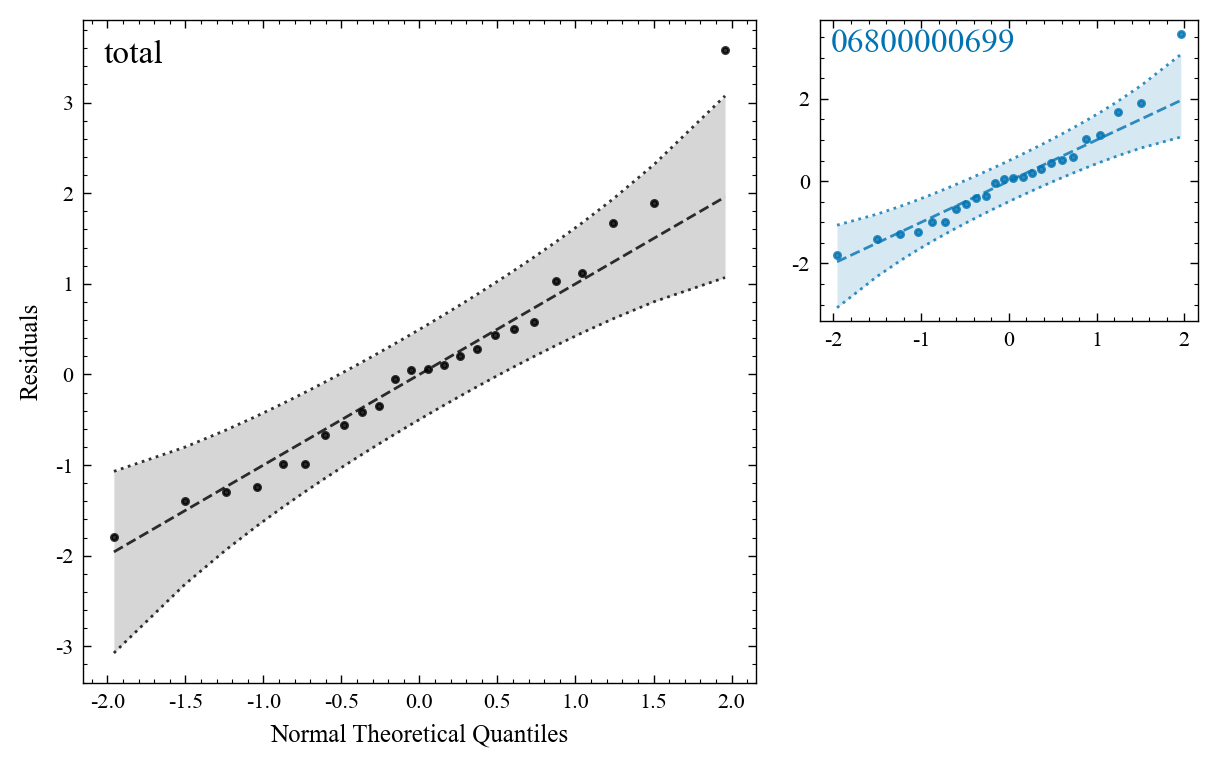

In [16]:
fig = posterior.plot.plot_qq(detrend=False)

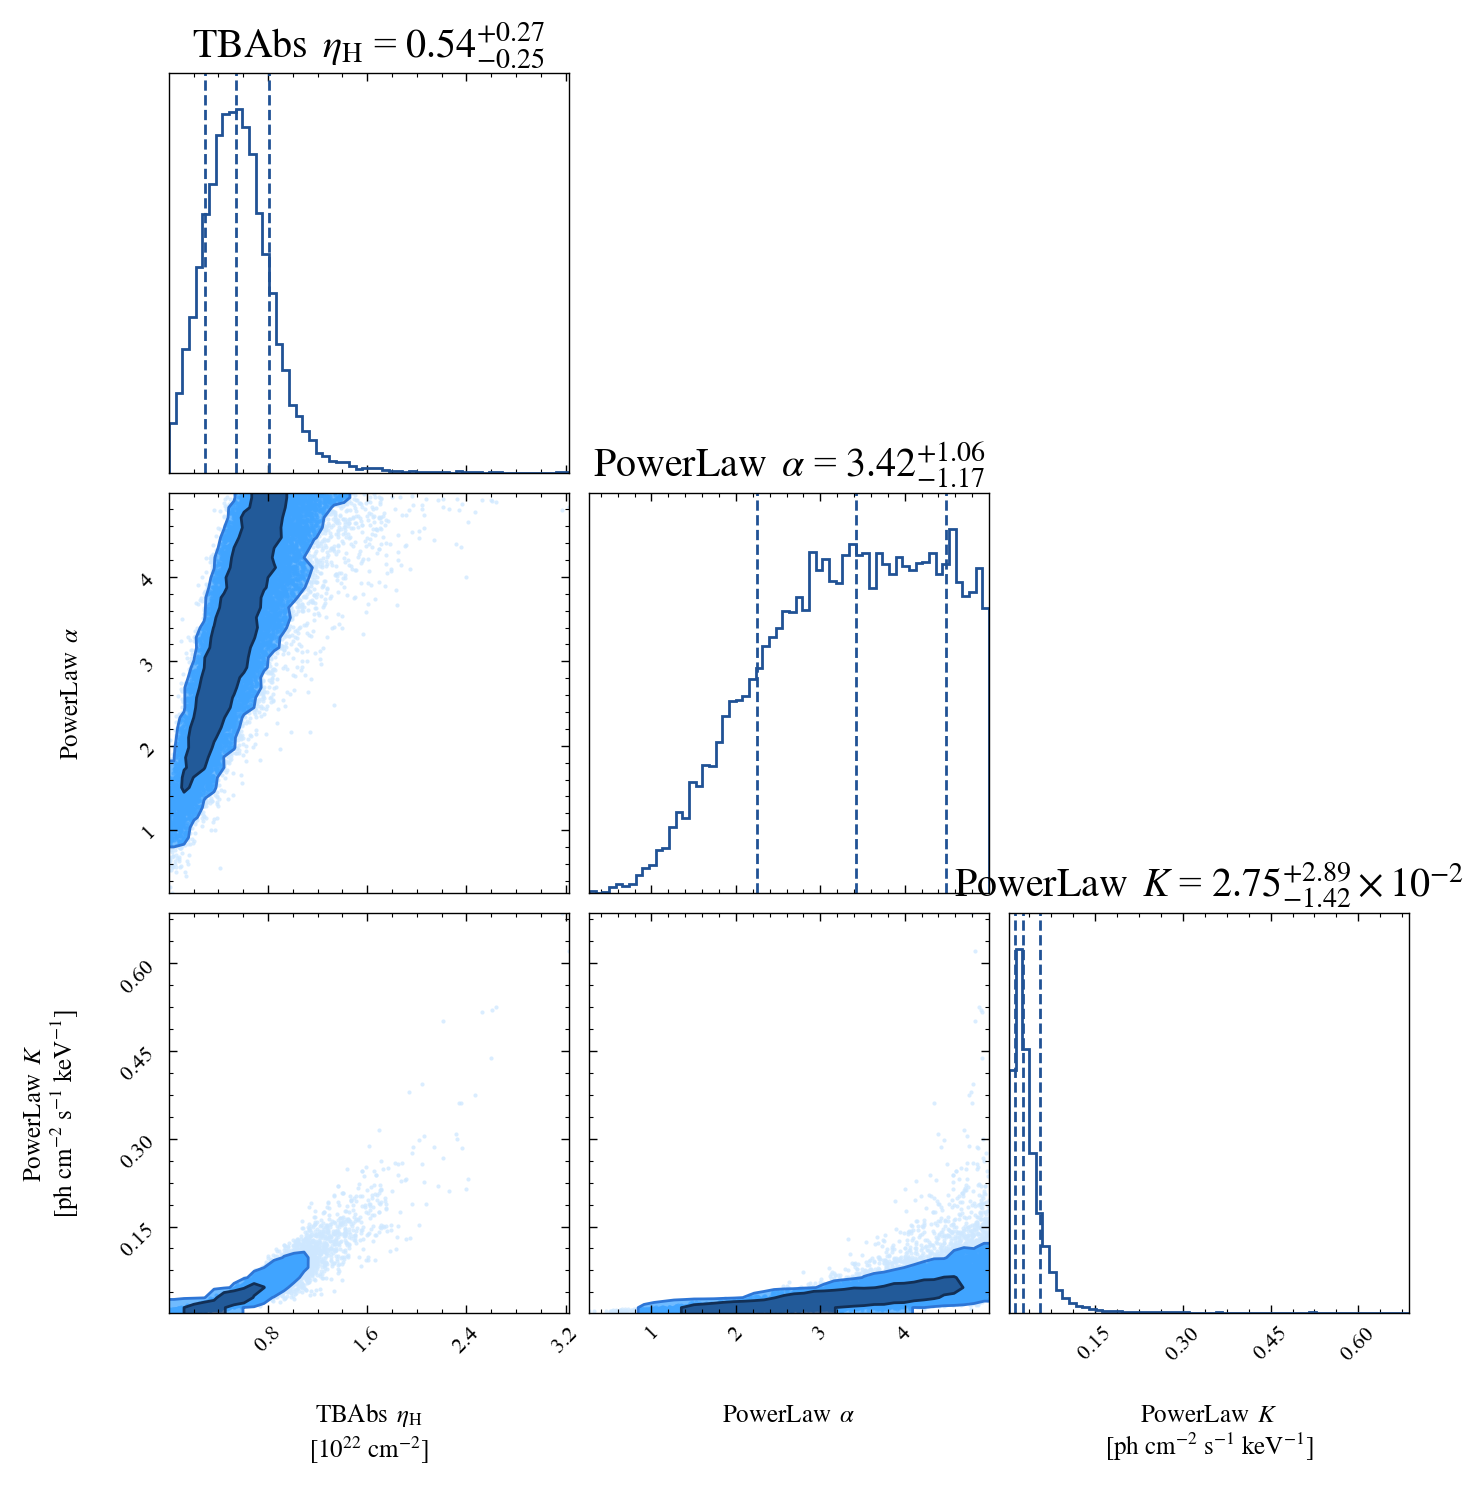

In [17]:
fig_corner = posterior.plot.plot_corner()

#### Maximum Likelihood Fit

In [21]:
#model.tbabs.nH.default = 0.35
fit2 = MaxLikeFit([WXT], model)
fit2

Maximum Likelihood Fit

╭─────────────┬──────────────────┬───────────╮
│     Data    │      Model       │ Statistic │
├─────────────┼──────────────────┼───────────┤
│ 06800000699 │ TBAbs * PowerLaw │   wstat   │
╰─────────────┴──────────────────┴───────────╯

╭─────┬───────────┬───────────┬───────┬────────────────╮
│ No. │ Component │ Parameter │ Value │     Bound      │
├─────┼───────────┼───────────┼───────┼────────────────┤
│  1  │   TBAbs   │     nH    │  0.34 │   (0, 1e+06)   │
├─────┼───────────┼───────────┼───────┼────────────────┤
│  2  │  PowerLaw │   alpha   │  1.8  │    (-1, 5)     │
├─────┼───────────┼───────────┼───────┼────────────────┤
│  3  │  PowerLaw │     K     │  1.1  │ (1e-05, 1e+04) │
╰─────┴───────────┴───────────┴───────┴────────────────╯

In [22]:
mle = fit2.mle(method='lm')
mle

Parameters
╭────────────────┬─────────┬──────────╮
│   Parameter    │   MLE   │  Error   │
├────────────────┼─────────┼──────────┤
│    TBAbs.nH    │  0.2507 │  0.2184  │
├────────────────┼─────────┼──────────┤
│ PowerLaw.alpha │  2.159  │  1.076   │
├────────────────┼─────────┼──────────┤
│   PowerLaw.K   │ 0.01247 │ 0.008548 │
╰────────────────┴─────────┴──────────╯

Fit Statistics
╭─────────────┬───────────┬──────────┬──────────╮
│     Data    │ Statistic │  Value   │ Channels │
├─────────────┼───────────┼──────────┼──────────┤
│ 06800000699 │   wstat   │  30.13   │    24    │
├─────────────┼───────────┼──────────┼──────────┤
│    Total    │  stat/dof │ 30.13/21 │    24    │
╰─────────────┴───────────┴──────────┴──────────╯

Information Criterion
╭────────┬───────╮
│ Method │ Value │
├────────┼───────┤
│  AIC   │ 37.33 │
├────────┼───────┤
│  BIC   │ 39.66 │
╰────────┴───────╯

Fit Status
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 30.13 (χ²/ndof = 1.4)      │         Nfcn = 83, Ngrad = 1         │
│ EDM = 1.04e-16 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

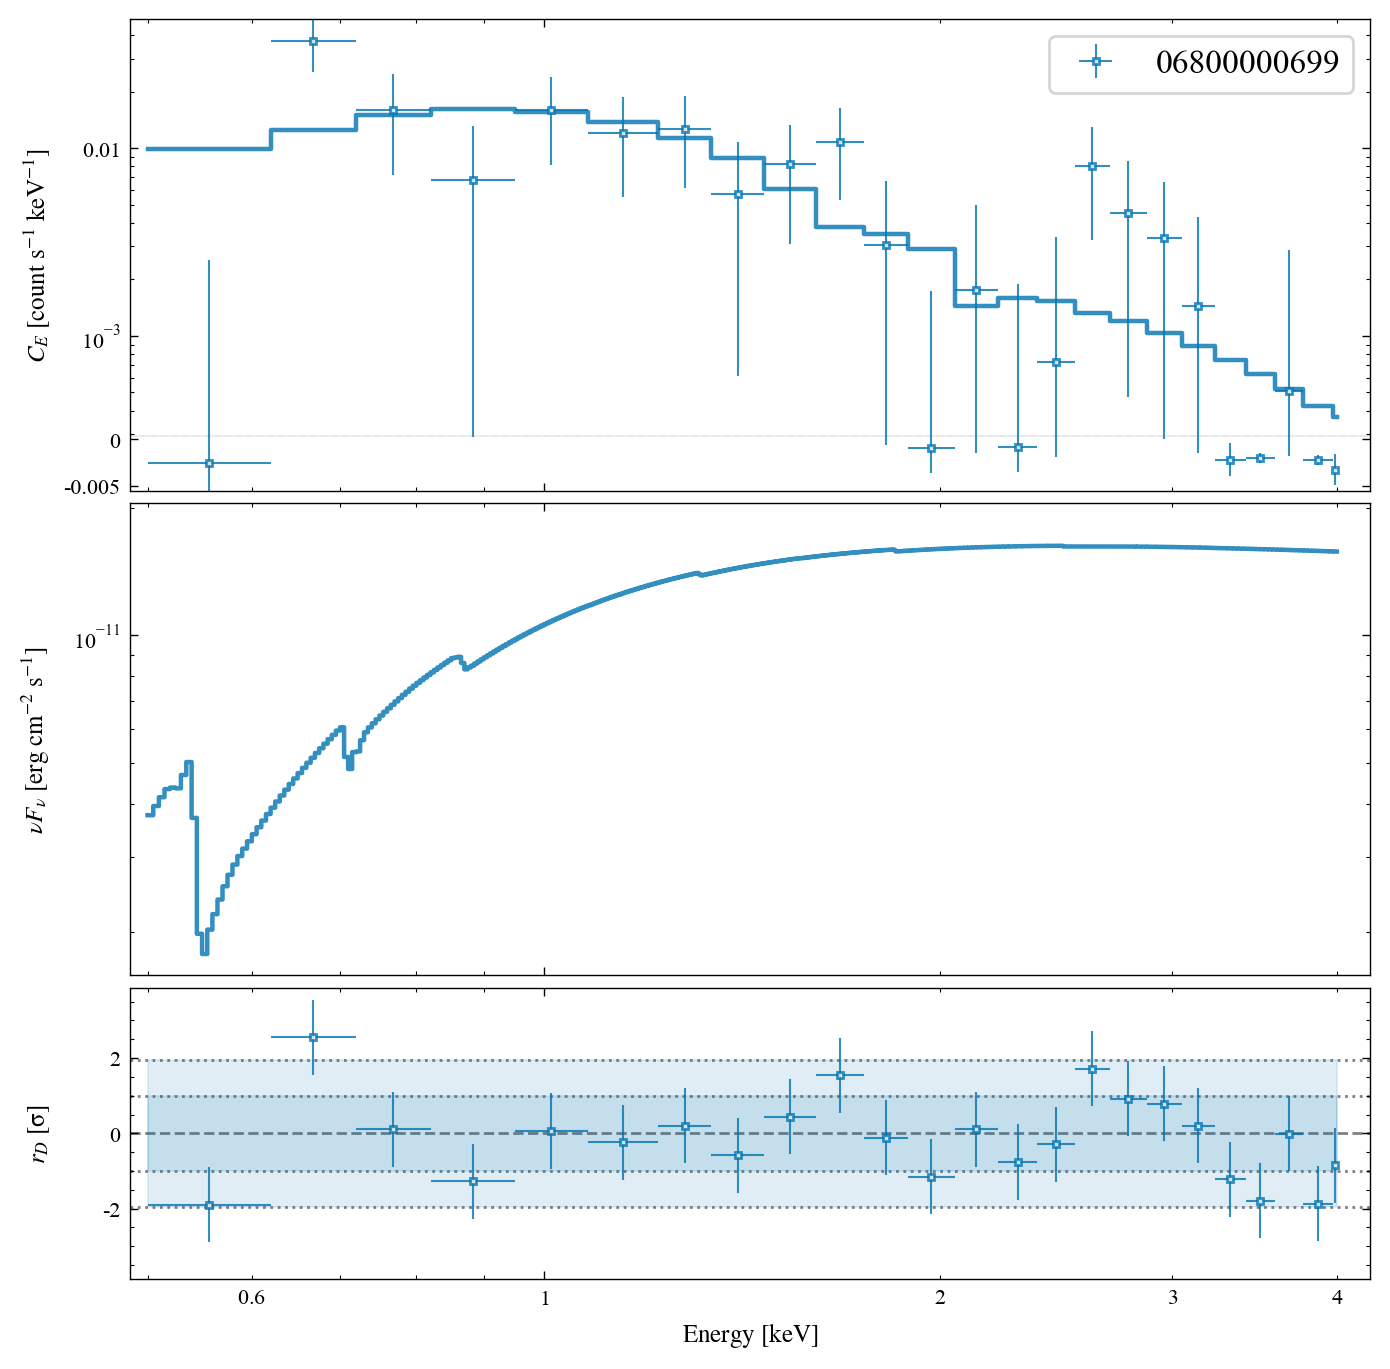

In [26]:
fig = mle.plot("data vFv rd")

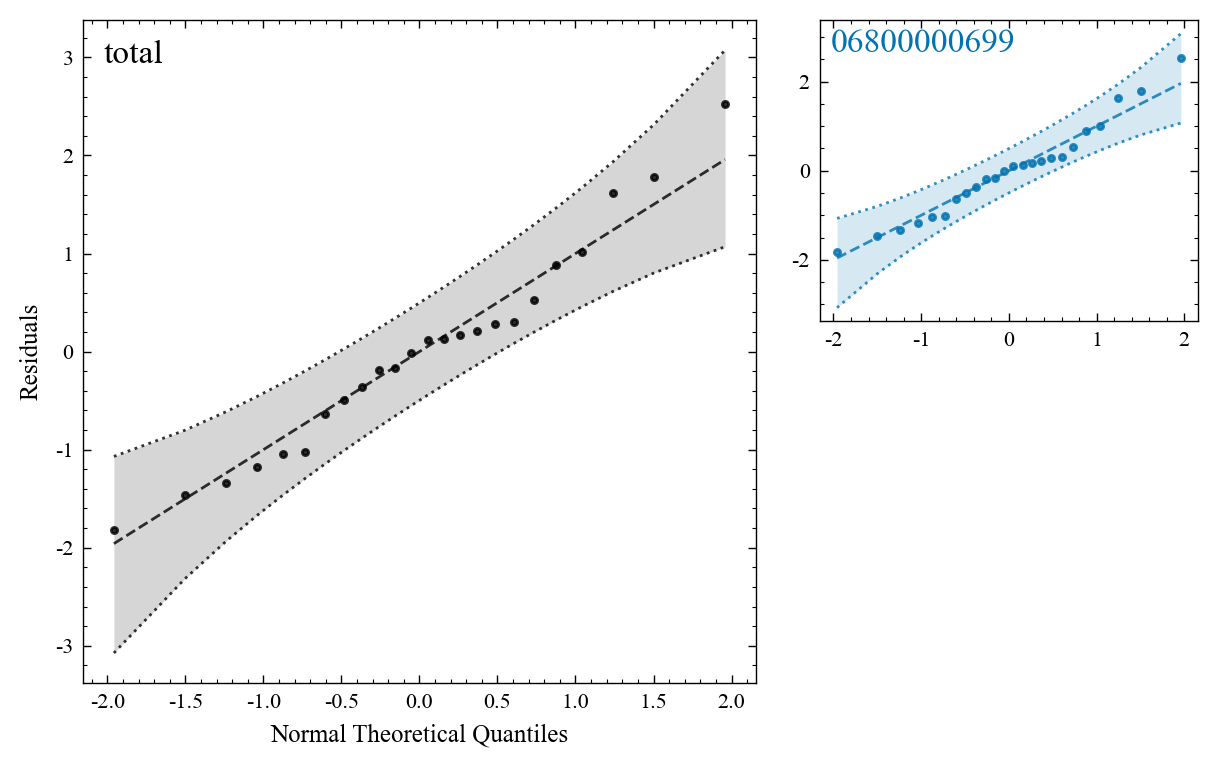

In [24]:
fig = mle.plot.plot_qq(detrend=False)

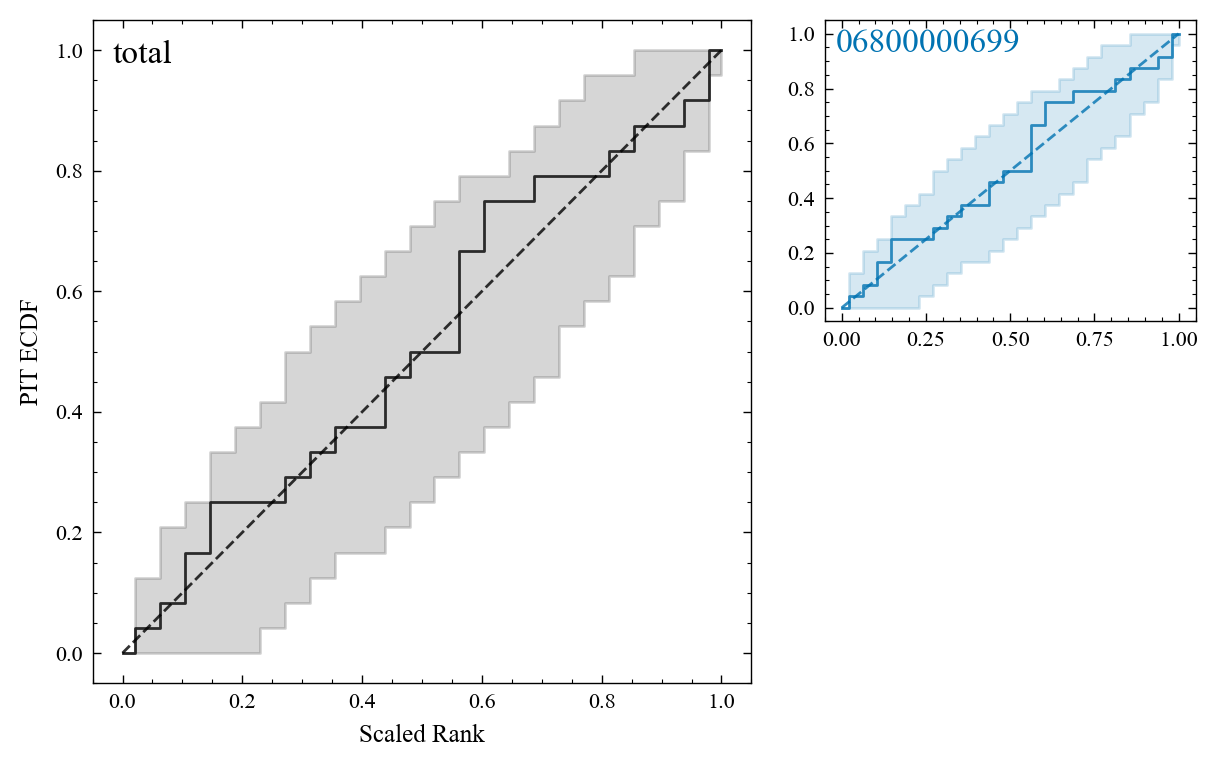

In [25]:
fig = mle.plot.plot_pit(detrend=False)

#### 4.3 `elisa`拟合结果不好的时候，写一个xcm。

先进入Xspec，@xspec_src.xcm，然后直接输入拟合的模型即可

In [ ]:
###  xcm
xspec_src = """data src1_spec.grp
ignore **-0.5 4.0-**
ignore bad
cpd /xw
statistic cstat
setpl en
abun wilm
"""
with open("xspec_src.xcm", "w") as f:
    f.write(xspec_src)